<a href="https://colab.research.google.com/github/AnkitaSK/AB-Image-Classification/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using pretrained model and using new output layer with the required number of classes


In [1]:
from keras.backend import clear_session

clear_session()

In [2]:
# importing libraries

import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from dataclasses import dataclass

from zipfile import ZipFile
from urllib.request import urlretrieve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_HEIGHT: int = 32
    IMG_WIDTH: int = 32
    CHANNELS: int = 3


@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS: int = 101
    LEARNING_RATE: float = 0.0001
    DROPOUT: float = 0.5
    LAYERS_FINE_TUNE: int = 15

In [4]:
SEED_VALUE = 41

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [5]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [6]:
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# separating training and validation set
X_valid = X_train[:10000]
X_train = X_train[10000:]

y_valid = y_train[:10000]
y_train = y_train[10000:]


# normalize the data by dividing by 255 to scale the pixel values between 0 and 1
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_valid = X_valid.astype("float32") / 255


# Convert the labels to one-hot encoded form.
y_train = tf.keras.utils.to_categorical(y_train, DatasetConfig.NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, DatasetConfig.NUM_CLASSES)
y_valid = tf.keras.utils.to_categorical(y_valid, DatasetConfig.NUM_CLASSES)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
# fine tuning
# we need to redefine the classifier
# Load the VGG16 model with pretrained ImageNet weights, excluding the top (fully connected) layers
input_shape = (
    DatasetConfig.IMG_HEIGHT,
    DatasetConfig.IMG_WIDTH,
    DatasetConfig.CHANNELS,
)

base_model = tf.keras.applications.vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=input_shape
)

base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Freeze the Initial Layers in the Convolutional Base
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below)
base_model.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(base_model.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in base_model.layers[: num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last {num_layers_fine_tune} convolution layers")
print("\n")
base_model.summary()

FREEZING LAYER: <InputLayer name=input_layer, built=True>
FREEZING LAYER: <Conv2D name=block1_conv1, built=True>
FREEZING LAYER: <Conv2D name=block1_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block1_pool, built=True>


Configured to fine tune the last 15 convolution layers




Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,675,968 (55.98 MB)

 Non-trainable params: 38,720 (151.25 KB)

In [9]:
# Add the Classifier to Complete the Model
model = Sequential(
    [
        base_model,  # Add the pretrained model (frozen initially)
        layers.GlobalAveragePooling2D(),  # Convert 4D tensor to 2D
        layers.Dense(256, activation="relu"),  # Fully connected layer
        layers.Dropout(TrainingConfig.DROPOUT),  # Prevent overfitting
        layers.Dense(
            DatasetConfig.NUM_CLASSES, activation="softmax"
        ),  # CIFAR-10 has 10 classes
    ]
)

# checkpoint
checkpoint = ModelCheckpoint(
    filepath="best_model_transfer_learning.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

# early stop to improve accuracy
early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
training_results = model.fit(
    X_train,
    y_train,
    epochs=TrainingConfig.EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint, early_stopping],
)

Epoch 1/101
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5046 - loss: 1.4285
Epoch 1: val_loss improved from inf to 0.69932, saving model to best_model_transfer_learning.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.5050 - loss: 1.4273 - val_accuracy: 0.7661 - val_loss: 0.6993
Epoch 2/101
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7930 - loss: 0.6470
Epoch 2: val_loss improved from 0.69932 to 0.55761, saving model to best_model_transfer_learning.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7930 - loss: 0.6469 - val_accuracy: 0.8174 - val_loss: 0.5576
Epoch 3/101
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8509 - loss: 0.4677
Epoch 3: val_loss did not improve from 0.55761
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8510 - loss: 0.4675 - val_accuracy: 0.8249 - val_loss: 0.5740
Epoch 4/101
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8873 - loss: 0.3493
Epoch 4: val_loss did not improve fr

In [10]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [
            metrics,
        ]
        metric_name = [
            metric_name,
        ]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, len(training_results.history["loss"])])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

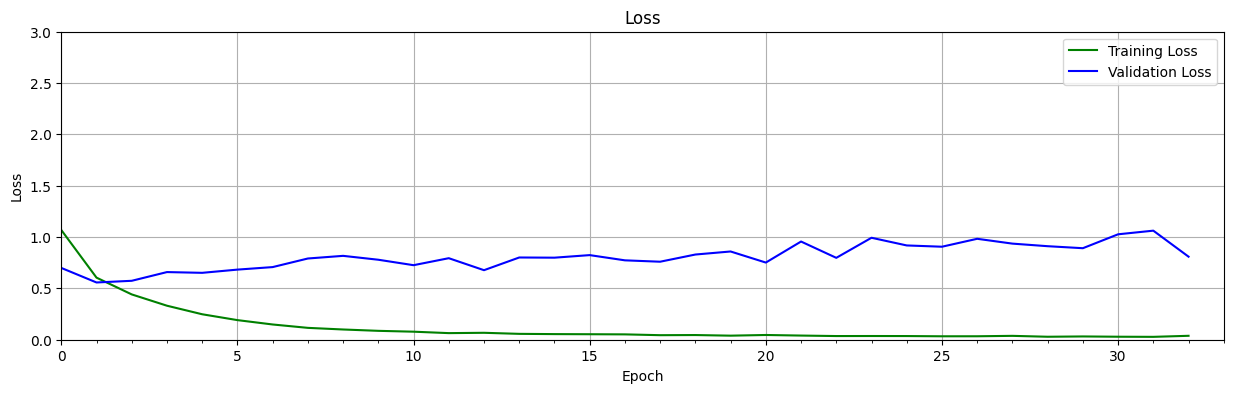

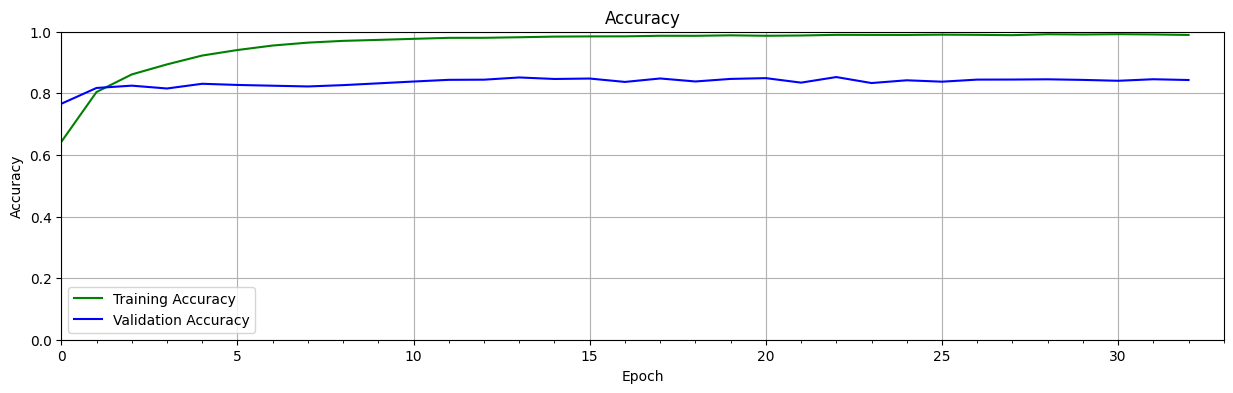

In [11]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc = training_results.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 3.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

In [12]:
valid_loss, valid_accuracy = model.evaluate(X_valid, y_valid)
print(
    f"Model valid accuracy: {valid_accuracy*100.:.3f}, Model valid loss: {valid_loss}"
)
print("\n\n")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Model test accuracy: {test_accuracy*100.:.3f}, Model test loss: {test_loss}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8554 - loss: 0.7536
Model valid accuracy: 85.280, Model valid loss: 0.7975761890411377



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8507 - loss: 0.8785
Model test accuracy: 84.610, Model test loss: 0.8829789161682129


In [13]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(train_loss)
print(train_accuracy)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9949 - loss: 0.0174
0.015053915791213512
0.9954000115394592


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


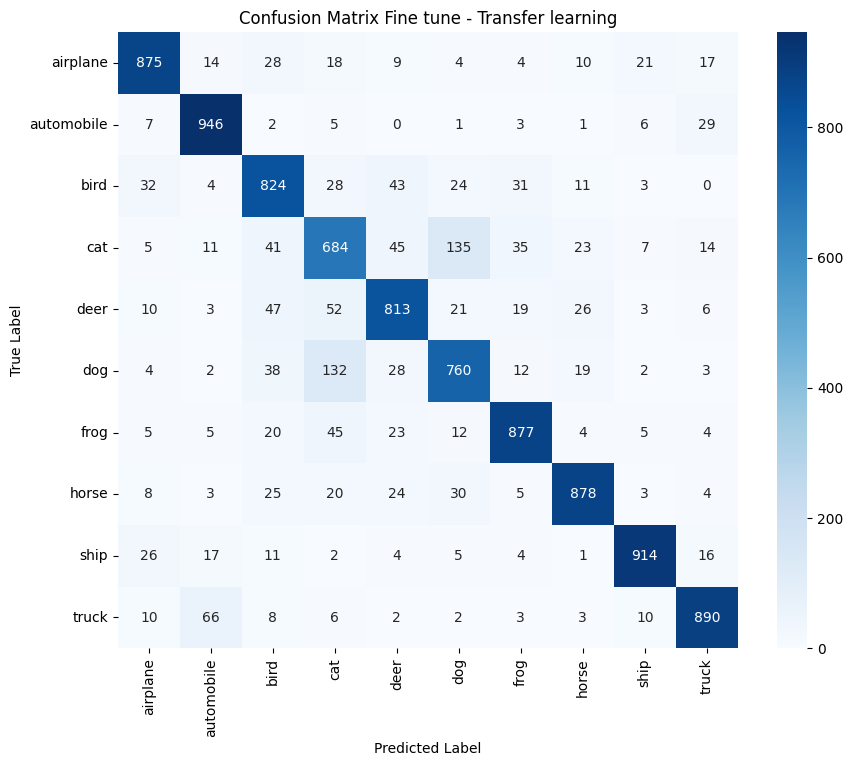

In [14]:
# confusion matrix
y_pred = model.predict(X_test)

predictions = np.argmax(y_pred, axis=1)
gt = np.argmax(y_test, axis=1)
cm = confusion_matrix(gt, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix Fine tune - Transfer learning")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

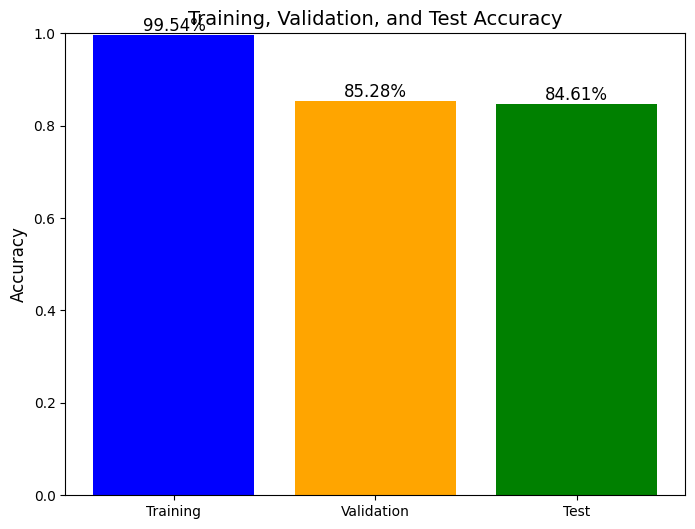

In [15]:
import matplotlib.pyplot as plt

# Labels for the bar chart
labels = ["Training", "Validation", "Test"]
# Accuracy values
accuracies = [train_accuracy, valid_accuracy, test_accuracy]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=["blue", "orange", "green"])

# Add title and labels
plt.title("Training, Validation, and Test Accuracy", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim([0, 1])  # Set y-axis from 0 to 1 (for percentages)

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center", fontsize=12)

# Show the plot
plt.show()